**suyeon_KSYLGBM2.ipynb참고**

In [38]:
import pandas as pd
import numpy as np
import os
import random

import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


In [39]:
path = '/opt/ml/input/data/'
# train = pd.read_csv(path + 'train_data.csv')
# test = pd.read_csv(path + 'test_data.csv')
dat = pd.read_csv(path + 'FE_total2.csv')

dat = dat.sort_values(by = ['userID', 'Timestamp'])
dat['tem'] = 0

_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] == -1]

In [40]:
# 데이터 증강하는 법.
def data_argument(train):
    _train = train.copy()
    _train.reset_index(drop = True, inplace= True)
    _train.loc[_train.drop_duplicates(subset='userID', keep = 'last').index, 'tem'] = -1
    _valid = _train[_train['tem'] == -1]
    _train = _train[_train['tem'] == 0]

    return _train, _valid

_train_x, _valid = data_argument(_train)
_train_x_1, _train_1 = data_argument(_train_x)
_train_x_2, _train_2 = data_argument(_train_x_1)
_train_x_3, _train_3 = data_argument(_train_x_2)
_train_x_4, _train_4 = data_argument(_train_x_3)
_train_x_5, _train_5 = data_argument(_train_x_4)
_train_x_6, _train_6 = data_argument(_train_x_5)
_train_x_7, _train_7 = data_argument(_train_x_6)
_train_x_8, _train_8 = data_argument(_train_x_7)
_train_x_9, _train_9 = data_argument(_train_x_8)
_train_x_10, _train_10 = data_argument(_train_x_9)

    


In [41]:
def data_merge(_train_x, _train_y): 
    # _train_x : 값 제공하는 전체 DB, _train_y : 현재 맞춰야 하는 유저와 아이템 상태.

    # 문제별로 평균값, 총 풀어진 개수 구하기.
    item1 = _train_x.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
    item1.columns = ["item_mean", 'item_sum']
    item1.reset_index(inplace=True)
    _train_x = pd.merge(_train_x, item1[['assessmentItemID','item_mean']], on=['assessmentItemID'], how='left')

    # 유저 단위 변수 추가

    # 유저가 평균적으로 얼마나 맞는지, 또 몇 문제 풀었는지.
    tem1 = _train_x.groupby('userID')['answerCode']
    tem1 = pd.DataFrame({'answer_mean' : tem1.mean(), 'answer_cnt':tem1.count()}).reset_index()
    # 유저가 평균적으로 몇 분안에 문제를 풀었는지.
    tem2 = _train_x.groupby('userID')['solve_time']
    tem2 = pd.DataFrame({'time_mean' : tem2.mean()}).reset_index()
    # 유저의 태그를 붙인 것 같은데 정확히 뭔지 모르겠음.
    tem3 = pd.DataFrame({'tag_mode' : _train_x.groupby('userID')['KnowledgeTag'].agg(pd.Series.mode)})
    tem3['tag_mode'] = tem3['tag_mode'].apply(lambda x : x if str(type(x)) =="<class 'numpy.int64'>" else x[0])
    # 유저가 지금까지 푼 문제의 평균 정답률은 어떻게 되는지 구하기.(어려운 문제를 풀어왔는가?)
    tem5 = _train_x.groupby(['userID'])['item_mean'].agg(['mean']).reset_index()
    tem5.columns = ["userID", 'user_item_mean']
    # tem4 = _train_x.groupby('userID')['answerCode'].apply(lambda x : x.iloc[-3:])
    # tem4 = pd.DataFrame({'last3_mean' : tem4.groupby('userID').mean()})

    user_df = pd.merge(tem1, tem2, on=['userID'], how='left')
    user_df = pd.merge(user_df, tem3, on=['userID'], how='left')
    user_df = pd.merge(user_df, tem5, on=['userID'], how='left')
    # user_df = pd.merge(user_df, tem4, on=['userID'], how='left')

    _train_y = pd.merge(_train_y[['userID', 'assessmentItemID', 'answerCode','last_answerCode',
    'last_answerCode2','last_answerCode3','last_answerCode4','last_answerCode5','last_answerCode6',
    'last_answerCode7','last_answerCode8','last_answerCode9','last_answerCode10']], user_df, on=['userID'], how='left')

    # 아이템 단위 변수 추가.

    # 해당 문제는 평균 정답률이 어떻게 되는가? + 학생이 몇 번이나 풀었던가?
    _train_y = pd.merge(_train_y, item1, on=['assessmentItemID'], how='left')
    # 해당 문제는 평균 풀이 시간이 어떻게 되는가?
    item2 = _train_x.groupby(['assessmentItemID'])['solve_time'].agg(['mean'])
    item2.columns = ["item_time_mean"]
    item2.reset_index(inplace=True)
    _train_y = pd.merge(_train_y, item2, on=['assessmentItemID'], how='left')

    return _train_y.drop(['userID','assessmentItemID'],axis=1)

test = data_merge(_train, _test)
valid = data_merge(_train_x, _valid)
train_1 = data_merge(_train_x_1, _train_1)
train_2 = data_merge(_train_x_2, _train_2)
train_3 = data_merge(_train_x_3, _train_3)
train_4 = data_merge(_train_x_4, _train_4)
train_5 = data_merge(_train_x_5, _train_5)
train_6 = data_merge(_train_x_6, _train_6)
train_7 = data_merge(_train_x_7, _train_7)
train_8 = data_merge(_train_x_8, _train_8)
train_9 = data_merge(_train_x_9, _train_9)
train_10 = data_merge(_train_x_10, _train_10)
train = pd.concat([train_1,train_2,train_3,train_4,train_5,train_6,train_7,train_8,train_9,train_10])
train = train[train['answer_cnt'] >= 14] # test에는 최소 14개의 문제 표본이 있는 유저만 있음.

In [ ]:
model = xgb.XGBClassifier(learning_rate= 3e-4, n_estimators=1000, max_depth = 9)
model.fit(train.drop(['answerCode'],axis=1), train['answerCode'], verbose=100,early_stopping_rounds=100, eval_metric='auc',eval_set=[(valid.drop(['answerCode'],axis=1), valid['answerCode'])])
preds = model.predict_proba(train.drop(['answerCode'],axis=1))[:,1]

acc = accuracy_score(train['answerCode'], np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(train['answerCode'], preds)
print(f'TRAIN AUC : {auc} ACC : {acc}\n')

preds = model.predict_proba(valid.drop(['answerCode'],axis=1))[:,1]
acc = accuracy_score(valid['answerCode'], np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(valid['answerCode'], preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')
# train 대비 Valid가 낮다. valid는 리더보드와 거의 동일하다.
# train에 모델 과적합. => 과적합 방지 하이퍼파라미터 튜닝 + 데이터 증강필요?

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.77320
[100]	validation_0-auc:0.77374
[200]	validation_0-auc:0.77656
[300]	validation_0-auc:0.77924
[400]	validation_0-auc:0.78119
[500]	validation_0-auc:0.78292
[600]	validation_0-auc:0.78424
[700]	validation_0-auc:0.78510
[800]	validation_0-auc:0.78586
[900]	validation_0-auc:0.78639
[999]	validation_0-auc:0.78675
TRAIN AUC : 0.8472521970719773 ACC : 0.7809485362696104

VALID AUC : 0.7867506572242338 ACC : 0.7135178715399086



Text(0.5, 1.0, 'Feature Importance')

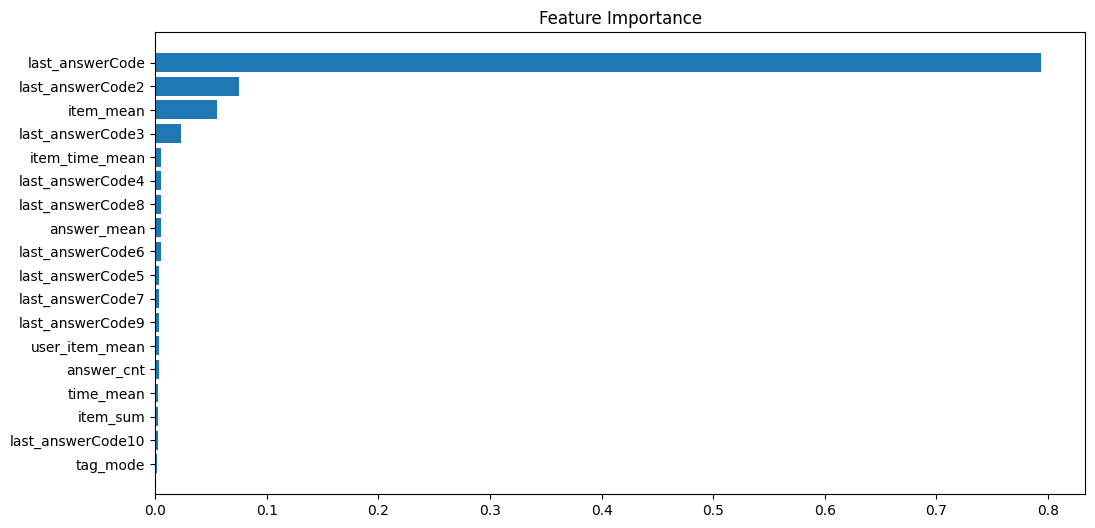

In [ ]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(valid.drop(['answerCode'],axis=1).columns)[sorted_idx])
plt.title("Feature Importance")

In [ ]:
# submission 제출하기 위한 코드

test_pred = model.predict_proba(test.drop(['answerCode'],axis=1))[:,1]
test['prediction'] = test_pred
submission = test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('../output/sequence_LGBM_submission4.csv', index = False)